# BiLSTM Classifier evaluation

In [1]:
# Import code from file in upper directory
import sys, os
sys.path.append(os.getcwd() + os.sep + os.pardir)

from tweet_data import TweetsBaseDataset, get_mapping
from bilstm import BiLSTMClassifier
from train import load_model
from evaluate import predict_dataset

from collections import Counter
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

We start by instantiating a model with empty embeddings, and then loading the weights from an already trained model.

In [2]:
embeddings = np.empty((10002, 300), dtype=np.float32)
model = BiLSTMClassifier(embeddings)
model = load_model(model, '../runs/Sep26_12-02-32_gpu-deep-learner/best-ckpt.pt')

Now we load the dataset to evaluate the model.

In [3]:
test_set = TweetsBaseDataset.load('../data/test/us_test.set')

Loaded dataset with 50000 tweets, 10002 unique tokens


Since the model makes predictions for padded sequences in mini-batches, where sequences are sorted by length, the order can differ from the order of the tweets in the original dataset, so when predicting we also retrieve the indices that correspond to the line number of the tweet in the original dataset.

In [4]:
y_true, y_pred, indices = predict_dataset(model, test_set)

In [5]:
metrics = [f1_score, precision_score, recall_score]

for metric in metrics:
    print(metric.__name__ + ': {:.4f}'.format(metric(y_true, y_pred, average='macro')))

f1_score: 0.3187
precision_score: 0.3252
recall_score: 0.3182


These results are slightly higher than the results for the baselines, but they are also lower than those observed in [1], which used a similar model. The difference might be due to the smaller vocabulary size that we used (10,000 words).

We can now examine the performance for each class. To gain further insight we will count the number of occurrences in the training set.

In [6]:
train_set = TweetsBaseDataset.load('../data/train/us_train.set')

Loaded dataset with 489609 tweets, 10002 unique tokens


For easier manipulation we will now create a DataFrame with emojis, counts and their respective metrics.

In [94]:
id_to_emoji = get_mapping('../data/mapping/us_mapping.txt')
ids = list(id_to_emoji.keys())
counter = Counter(train_set.labels)
scores = pd.DataFrame(list(id_to_emoji.values()), columns=['emoji'])
scores['count'] = [counter[i] for i in id_to_emoji]
# Add metrics
for i, metric in enumerate(metrics):
    scores[metric.__name__] = metric(y_true, y_pred, average=None)
    
scores = scores.sort_values(by='count', axis=0, ascending=False)

In [95]:
scores

,emoji,count,f1_score,precision_score,recall_score
0,❤,106319,0.837356,0.836041,0.838674
1,😍,51267,0.329401,0.304754,0.358385
2,😂,50374,0.409756,0.386983,0.435377
3,💕,27030,0.204512,0.226848,0.186180
4,🔥,24404,0.491002,0.537993,0.451561
5,😊,23086,0.124257,0.110101,0.142591
6,😎,21103,0.191183,0.169374,0.219439
7,✨,18130,0.280908,0.332835,0.242997
8,💙,16825,0.180766,0.205423,0.161394
9,😘,15959,0.155172,0.143791,0.168511


Is there a relationship between label frequency and model performance?

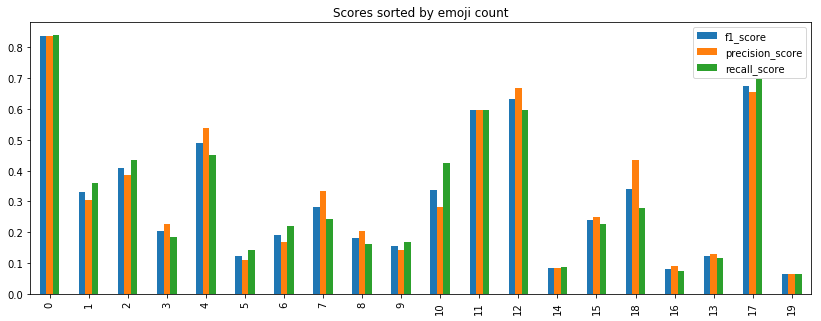

In [96]:
scores.drop('count', axis=1).plot.bar(title='Scores sorted by emoji count', figsize=(14, 5));

According to these results, even for unfrequent labels the model is able to obtain high scores for some emojis, such as emoji 17, which corresponds to the Christmas tree. We can hypothesize that emojis like the Christmas tree are easy to predict from the sole presence of particular words in the input, whereas for other emojis the relationship is not so obvious during prediction and might lead to similar labels in some cases. We can examine this using the confusion matrix. Due to the imbalance in the classes, this matrix is best visualized by taking a fractional power of the values:

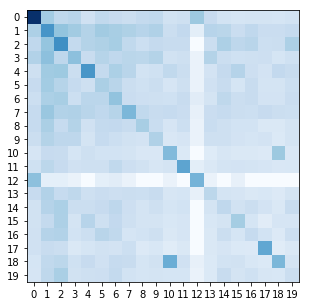

In [102]:
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(confusion**0.3, cmap='Blues')
plt.xticks(ids);
plt.yticks(ids);

We can see that:

- When predicting a sun (12), the model often wrongly predicts a heart (0), and viceversa. The confusion with other labels is much lower, which explains why the F1 score for these two is the highest over all the emojis.
- The camera (10) and its flashing version (18) are frequently mixed up. This might be because of their visual similarity, which results in people using both in similar tweets.
- The 'winking face with tongue' emoji (19) has the lowest score and we see that it is easily confused with any other emoji, in particular with the 'face_with_tears_of_joy' (2).

Let's now observe some failure cases for each emoji.

In [124]:
from IPython.display import display, Markdown, Latex

In [130]:
max_failures = 5
all_failures = [[] for i in ids]
predictions = [[] for i in ids]
inverse_vocab = {idx: word for word, idx in train_set.vocabulary.items()}

for i, y in enumerate(y_true):
    if sum([len(failures) for failures in all_failures]) == max_failures * len(ids):
        break
    
    if len(all_failures[y]) < max_failures and y != y_pred[i]:
        text_ids, _, _ = test_set[indices[i]]
        text_ids = text_ids.data.numpy()
        
        text = " ".join([inverse_vocab[idx] for idx in text_ids])
        
        all_failures[y].append(text)
        predictions[y].append(y_pred[i])
        
for i, failures in enumerate(all_failures):
    print('Emoji: {}'.format(id_to_emoji[i]))
    for j, fail in enumerate(failures):
        print('\t' + fail)
        print('\tPredicted: {}\n'.format(id_to_emoji[predictions[i][j]]))
    print('-'*100)

Emoji: ❤
	this is how we roll ! <hashtag> x men </hashtag> <hashtag> <UNK> </hashtag> <hashtag> storm </hashtag> <hashtag> <UNK> </hashtag> <hashtag> cosplay </hashtag> <hashtag> costumes </hashtag> <hashtag> halloween </hashtag> …
	Predicted: 😉

	private dining ️ colin + martin ! <hashtag> congrats </hashtag> <user> <hashtag> photography </hashtag> ( @ lee - <user> in toronto , on )
	Predicted: ☀

	just watched this film and it was very heart warming and a beautiful story • • <hashtag> film </hashtag> <hashtag> movie </hashtag> …
	Predicted: 💕

	merry merry christmas to you all . may god <UNK> our hearts with …
	Predicted: 🎄

	this summer was one to remember because of them ️ @ north cypress …
	Predicted: ☀

----------------------------------------------------------------------------------------------------
Emoji: 😍
	this gold ' s has iron plates . i think i am in love . deadlifts . <number> , <number> , <number> & <number> . sets of <number> - <number> . …
	Predicted: 😂

	almost <tim

### References

[1] Barbieri, Francesco, Miguel Ballesteros, and Horacio Saggion. "Are Emojis Predictable?." arXiv preprint arXiv:1702.07285 (2017).